## Dilation and Erosion with Horizontal SE
It doesn't joint vertical pixels, so text cannot smudge to box.

In [1]:
from importlib import reload
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipcv import cvlib, scanner
import utility.notebook_helper as nb
from ipcv.cvlib import gaussian_blur

reload(nb)
reload(cvlib)
reload(scanner)

<module 'ipcv.scanner' from '/Users/everhett/Projects/python-ws/qr-scanner/ipcv/scanner.py'>

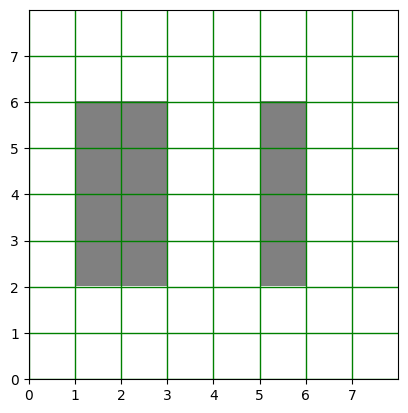

In [376]:
# O-shape: Closing is obvious in this.
mat1 = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]
])

horizontal_se = np.array([
    [1, 1, 1]
])

# Need to convert them first for cv operations.
mat1 = mat1.astype('uint8')
horizontal_se = horizontal_se.astype('uint8')

nb.display_color_grids(mat1)

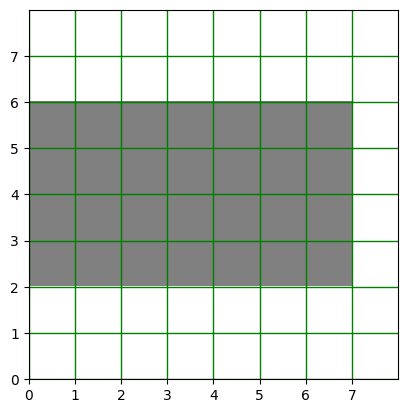

In [377]:
dilated = cv2.dilate(mat1, horizontal_se, iterations=1)
nb.display_color_grids(dilated)

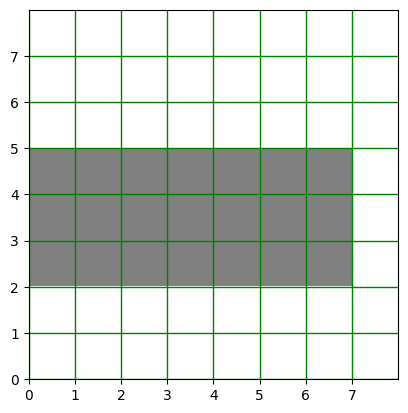

In [378]:
# Removes line from top and bottom.
# vertical_se = np.array([
#     [1],
#     [1],
#     [1]
# ])

# Removes line from top.
vertical_se = np.array([
    [1],
    [1]
])
eroded = cv2.erode(dilated, vertical_se, iterations=1)
nb.display_color_grids(eroded)

In [379]:
np.array_equal(mat1, eroded)

False

## Experiment the theory with a gray image

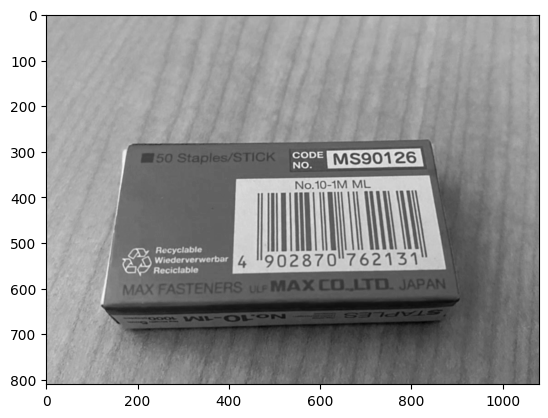

In [75]:
source = cvlib.load_image('../resources/barcode/barcode500.jpg')
# image = cvlib.convert_rgb2gray(image)

image = scanner.preprocess_image(source,
                                 gamma=1,
                                 gaussian_ksize=(3, 3),
                                 gaussian_sigma=1)
plt.imshow(image, cmap='gray')

[  0 255]


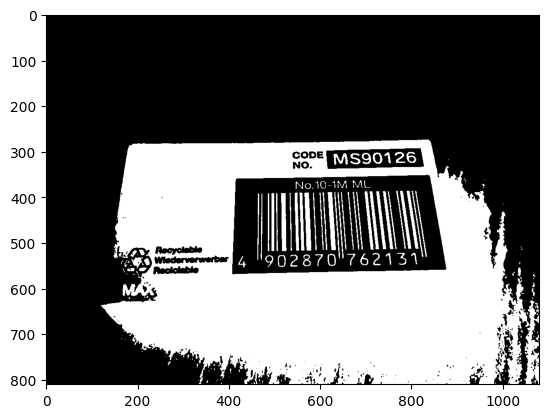

In [78]:
binary = cvlib.binarize_inv(image, 110)
# binary = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
unique = np.unique(binary)
print(unique)
plt.imshow(binary, cmap='gray')

## Erosion on dilated with cross SE (on image)

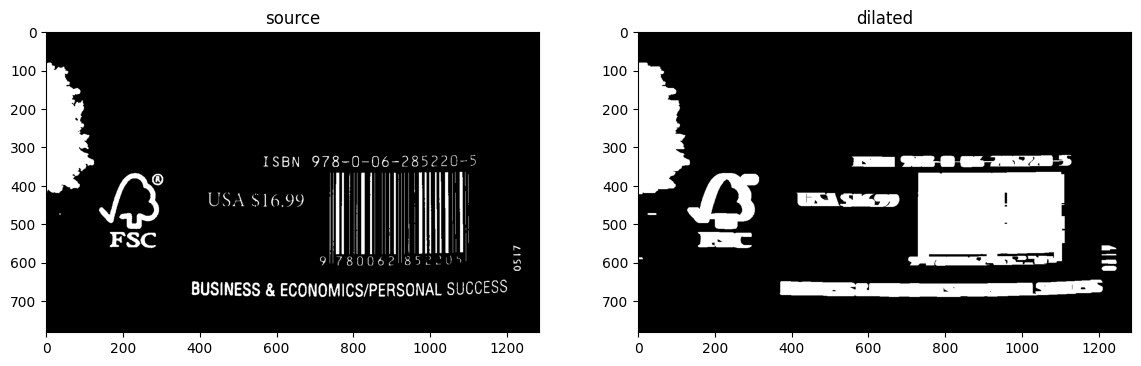

In [383]:
dilated_image = cv2.dilate(binary, horizontal_se, iterations=10)
nb.display_for_comparisons(binary, dilated_image, 'source', 'dilated')

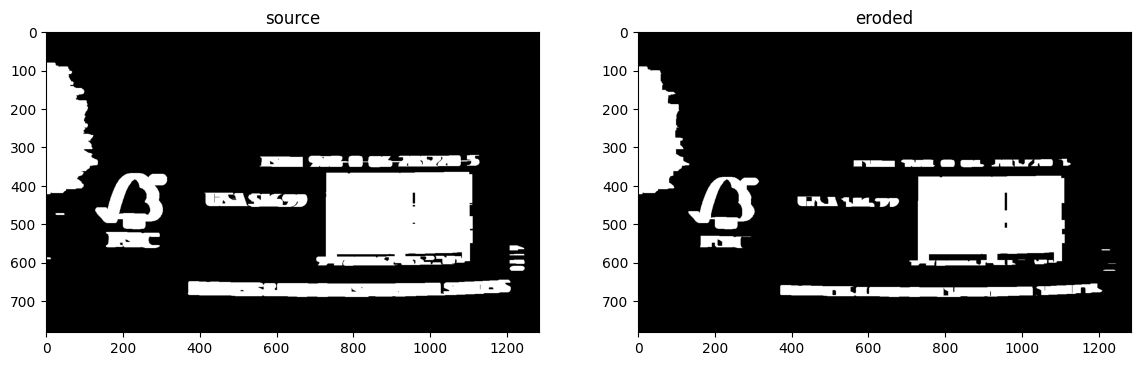

In [384]:
eroded_image = cv2.erode(dilated_image, vertical_se, iterations=10)
nb.display_for_comparisons(dilated_image, eroded_image, 'source', 'eroded')

In [1]:
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)

contours, _ = cv2.findContours(eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_area = image.shape[0] * image.shape[1]
required_aspect_ration = image_area / 45

print(f'Image Area: {image_area}')
print(f'Required ratio: {required_aspect_ration}')
cropped = None
print(f'Number of contours found: {len(contours)}\n')

max_contour = None
max_area = 0
for contour in contours:
    # print(f'\nContour len: {len(contour)}')
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
    # print(f'Approx len: {len(approx)}')
    cv2.drawContours(source, [approx], -1, GREEN, 3)
    if len(approx) == 4:
        area = cv2.contourArea(contour)
        print(f'Calculated area: {area}')

        (x, y, w, h) = cv2.boundingRect(approx)
        aspect_ratio = w / float(h)
        print(f'Calculate ratio: {aspect_ratio}')

        # Ensure the QR-Code is a box shaped (max ratio of w:h = 1.2:1)
        # AND min area => 12 x 10
        # if area > 100 and 0.8 <= aspect_ratio <= 1.2:
        # if area > required_aspect_ration and 0.8 <= aspect_ratio <= 1.2:
        if area > required_aspect_ration:
            # if 0.8 <= aspect_ratio <= 1.2:
            if area > max_area:
                max_area = area
                print(f'Max-Area: {max_area}')
                max_contour = contour
        print('\r')

if max_contour is not None:
    perimeter = cv2.arcLength(max_contour, True)
    approx = cv2.approxPolyDP(max_contour, 0.04 * perimeter, True)
    cv2.drawContours(source, [approx], -1, BLUE, 3)
    (x, y, w, h) = cv2.boundingRect(approx)
    cropped = image[y:y + h, x:x + w]

plt.imshow(source, cmap='gray')

NameError: name 'cv2' is not defined

In [387]:
decoded_text = scanner.decode_barcode(cropped)
if decoded_text is not None:
    print(decoded_text)

9780062852205
